# Retirement Model

This is a retirement model which models salary with both a constant growth rate for cost of living raises as well as regular salary increases for promotions. The model is broken up into the following sections:

- [**Setup**](#Setup): Runs any imports and other setup
- [**Inputs**](#Inputs): Defines the inputs for the model
- [**Salaries**](#Salaries): Determining the salary in each year, considering cost of living raises and promotions
- [**Wealths**](#Wealths): Determining the wealth in each year, considering a constant savings rate and investment rate
- [**Retirement**](#Retirement): Determines years to retirement from the wealths over time, the main output from the model.
- [**Results Summary**](#Results-Summary): Summarize the results with some visualizations
- [**Sensitivity Analysis**](#Sensitivity-Analysis): Determine how sensitive the years to retirement is to the model inputs
- [**Scenario Analysis**](#Scenario-Analysis): Examine cases of a bad, normal, and good economy to determine the years to retirement in these cases

## Setup

Setup for the later calculations are here. The necessary packages are imported.

In [1]:
from dataclasses import dataclass
import pandas as pd
import random
%matplotlib inline
from sensitivity import SensitivityAnalyzer
import random

## Inputs

All of the inputs for the model are defined here. A class is constructed to manage the data, and an instance of the class containing the default inputs is created.

In [2]:
@dataclass
class ModelInputs:
    starting_salary: int = 60000
    promos_every_n_years: int = 5
    cost_of_living_raise: float = 0.02
    promo_raise: float = 0.15
    savings_rate: float = 0.25
    interest_rate: float = 0.05
    desired_cash: int = 1500000
        
model_data = ModelInputs()
model_data

ModelInputs(starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, desired_cash=1500000)

## Salaries

Here the salary for each year is calculated. We assume that the salary grows at a constant rate each year for cost of living raises, and then also every number of years, the salary increases by a further percentage due to a promotion or switching jobs. Based on this assumption, the salary would evolve over time with the following equation:

$$s_t = s_0 (1 + r_{cl})^n (1 + r_p)^p$$

Where:
- $s_t$: Salary at year $t$
- $s_0$: Starting salary (year 0)
- $r_{cl}$: Annual cost of living raise
- $r_p$: Promotion raise
- $p$: Number of promotions

And in Python format:

In [3]:
def salary_at_year(data: ModelInputs, year):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years)
    
    # This is the formula above implemented in Python
    salary_t = data.starting_salary * (1 + data.cost_of_living_raise) ** year * (1 + data.promo_raise) ** num_promos
    return salary_t

That function will get the salary at a given year, so to get all the salaries we just run it on each year. But we will not know how many years to run as we should run it until the individual is able to retire. So we are just showing the first few salaries for now and will later use this function in the [Wealths](#Wealths) section of the model.

In [4]:
for i in range(6):
    year = i + 1
    salary = salary_at_year(model_data, year)
    print(f'The salary at year {year} is ${salary:,.0f}.')

The salary at year 1 is $61,200.
The salary at year 2 is $62,424.
The salary at year 3 is $63,672.
The salary at year 4 is $64,946.
The salary at year 5 is $76,182.
The salary at year 6 is $77,705.


As expected, with the default inputs, the salary is increasing at 2% per year. Then at year 5, there is a promotion so there is a larger increase in salary.

## Wealths

The wealths portion of the model is concerned with applying the savings rate to the earned salary to calculate the cash saved, accumulating the cash saved over time, and applying the investment rate to the accumulated wealth.

To calculate cash saved, it is simply:

$$c_t = s_t * r_s$$

Where:
- $c_t$: Cash saved during year $t$
- $r_s$: Savings rate

In [5]:
def cash_saved_during_year(data: ModelInputs, year):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year)
    cash_saved = salary * data.savings_rate
    return cash_saved

To get the wealth at each year, it is just applying the investment return to last year's wealth, then adding this year's cash saved:

$$w_t = w_{t-1} (1 + r_i) + c_t$$
Where:
- $w_t$: Wealth at year $t$
- $r_i$: Investment rate

In [6]:
def wealth_at_year(data: ModelInputs, year, prior_wealth):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year)
    wealth = prior_wealth * (1 + data.interest_rate) + cash_saved
    return wealth

Again, just like in the [Salaries](#Salaries) section, we can now get the output for each year, but we don't know ultimately how many years we will have to run it. That will be determined in the [Retirement](#Retirement) section. So for now, just show the first few years of wealth accumulation:

In [7]:
prior_wealth = 0  # starting with no cash saved
for i in range(6):
    year = i + 1
    wealth = wealth_at_year(model_data, year, prior_wealth)
    print(f'The wealth at year {year} is ${wealth:,.0f}.')
    
    # Set next year's prior wealth to this year's wealth
    prior_wealth = wealth

The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.


With default inputs, the wealth is going up by approximately 25% of the salary each year, plus a bit more for investment. Then in year 6 we see a substantially larger increase because the salary is substantially larger due to the promotion. So everything is looking correct.

## Retirement

This section of the model puts everything together to produce the final output of years to retirement. It uses the logic to get the wealths at each year, which in turn uses the logic to the get salary at each year. The wealth at each year is tracked over time until it hits the desired cash. Once the wealth hits the desired cash, the individual is able to retire so that year is returned as the years to retirement.

In [8]:
def years_to_retirement(data: ModelInputs, print_output=True):
    
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0  # will become 1 on first loop
    
    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

With the default inputs:

In [9]:
years = years_to_retirement(model_data)

Wealths over time:
The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.
The wealth at year 7 is $139,775.
The wealth at year 8 is $166,975.
The wealth at year 9 is $195,939.
The wealth at year 10 is $229,918.
The wealth at year 11 is $266,080.
The wealth at year 12 is $304,542.
The wealth at year 13 is $345,431.
The wealth at year 14 is $388,878.
The wealth at year 15 is $439,025.
The wealth at year 16 is $492,294.
The wealth at year 17 is $548,853.
The wealth at year 18 is $608,878.
The wealth at year 19 is $672,557.
The wealth at year 20 is $745,168.
The wealth at year 21 is $822,190.
The wealth at year 22 is $903,859.
The wealth at year 23 is $990,422.
The wealth at year 24 is $1,082,140.
The wealth at year 25 is $1,185,745.
The wealth at year 26 is $1,295,520.
The wealth at year 27 is $1,411,793.
The wealth at year 28 is $1,534,910.

Reti

# Results Summary

## Put Results in a Table

Now I will visualize the salaries and wealths over time. First create a function which runs the model to put these results in a DataFrame.

In [10]:
def get_salaries_wealths_df(data):
    """
    Runs the retirement model, collecting salary and wealth information year by year and storing
    into a DataFrame for further analysis.
    """
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0  # will become 1 on first loop
    
    df_data_tups = []
    while wealth < data.desired_cash:
        year = year + 1
        salary = salary_at_year(data, year)
        wealth = wealth_at_year(data, year, prior_wealth)

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
        # Save the results in a tuple for later building the DataFrame
        df_data_tups.append((year, salary, wealth))
        
    # Now we have exited the while loop, so wealth must be >= desired_cash
    
    # Now create the DataFrame
    df = pd.DataFrame(df_data_tups, columns=['Year', 'Salary', 'Wealth'])
    
    return df

Also set up a function which formats the `DataFrame` for display.

In [11]:
def styled_salaries_wealths(df):
    return df.style.format({
        'Salary': '${:,.2f}',
        'Wealth': '${:,.2f}'
    })

Now call the function to save the results into the `DataFrame`.

In [12]:
df = get_salaries_wealths_df(model_data)
styled_salaries_wealths(df)

,Year,Salary,Wealth
0,1,"$61,200.00","$15,300.00"
1,2,"$62,424.00","$31,671.00"
2,3,"$63,672.48","$49,172.67"
3,4,"$64,945.93","$67,867.79"
4,5,"$76,181.58","$90,306.57"
5,6,"$77,705.21","$114,248.20"
6,7,"$79,259.31","$139,775.44"
7,8,"$80,844.50","$166,975.33"
8,9,"$82,461.39","$195,939.45"
9,10,"$96,727.21","$229,918.22"


## Plot Results

Now I will visualize the salaries and wealths over time.

### Salaries over Time

<AxesSubplot:xlabel='Year'>

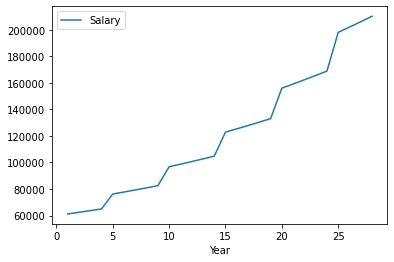

In [13]:
df.plot.line(x='Year', y='Salary')

### Wealths over Time

<AxesSubplot:xlabel='Year'>

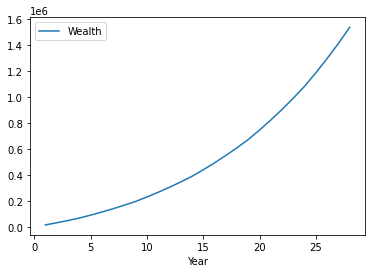

In [14]:
df.plot.line(x='Year', y='Wealth')

<AxesSubplot:xlabel='Year'>

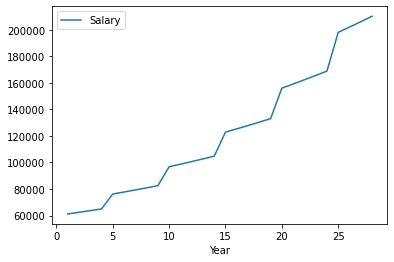

In [15]:
df.plot.line(x='Year', y='Salary')

# Sensitivity Analysis

Now I will determine how much the years to retirement changes in response to the different inputs. To use `SensitivityAnalyzer`, first we need a function which accepts the individual parameters rather than the entire data.

In [16]:
def years_to_retirement_separate_args(
    starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, 
    promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, desired_cash=1500000
):
    data = ModelInputs(
        starting_salary=starting_salary, 
        promos_every_n_years=promos_every_n_years, 
        cost_of_living_raise=cost_of_living_raise, 
        promo_raise=promo_raise, 
        savings_rate=savings_rate, 
        interest_rate=interest_rate, 
        desired_cash=desired_cash
    )
    
    return years_to_retirement(data, print_output=False)

years_to_retirement_separate_args()

28

Now pick the values we want to look at for each input.

In [17]:
# It is certainly possible to specify all these hard-coded but using list comprehensions makes it easy to adjust
sensitivity_values = {
    'starting_salary': [i * 10000 for i in range(4, 8)],
    'promos_every_n_years': [i for i in range(4, 8)],
    'cost_of_living_raise': [i/100 for i in range(1, 4)],
    'promo_raise': [i/100 for i in range(10, 25, 5)],
    'savings_rate': [i/100 for i in range(10, 50, 10)],
    'interest_rate': [i/100 for i in range(3, 8)],
    'desired_cash': [i * 100000 for i in range(10, 26, 5)]
}

In [18]:
sa = SensitivityAnalyzer(
    sensitivity_values,
    years_to_retirement_separate_args,
    result_name='Years to Retirement',
    reverse_colors=True,
    grid_size=3
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11520/11520 [00:16<00:00, 696.06it/s]


Now we've just run the model 11,520 times with all the combinations of the inputs.

In [19]:
sa.df

,starting_salary,promos_every_n_years,cost_of_living_raise,promo_raise,savings_rate,interest_rate,desired_cash,Years to Retirement
0,40000,4,0.01,0.1,0.1,0.03,1000000,52
1,40000,4,0.01,0.1,0.1,0.03,1500000,60
2,40000,4,0.01,0.1,0.1,0.03,2000000,66
3,40000,4,0.01,0.1,0.1,0.03,2500000,71
4,40000,4,0.01,0.1,0.1,0.04,1000000,47
...,...,...,...,...,...,...,...,...
11515,70000,7,0.03,0.2,0.4,0.06,2500000,25
11516,70000,7,0.03,0.2,0.4,0.07,1000000,16
11517,70000,7,0.03,0.2,0.4,0.07,1500000,19
11518,70000,7,0.03,0.2,0.4,0.07,2000000,22


Display as hex-bin plots.

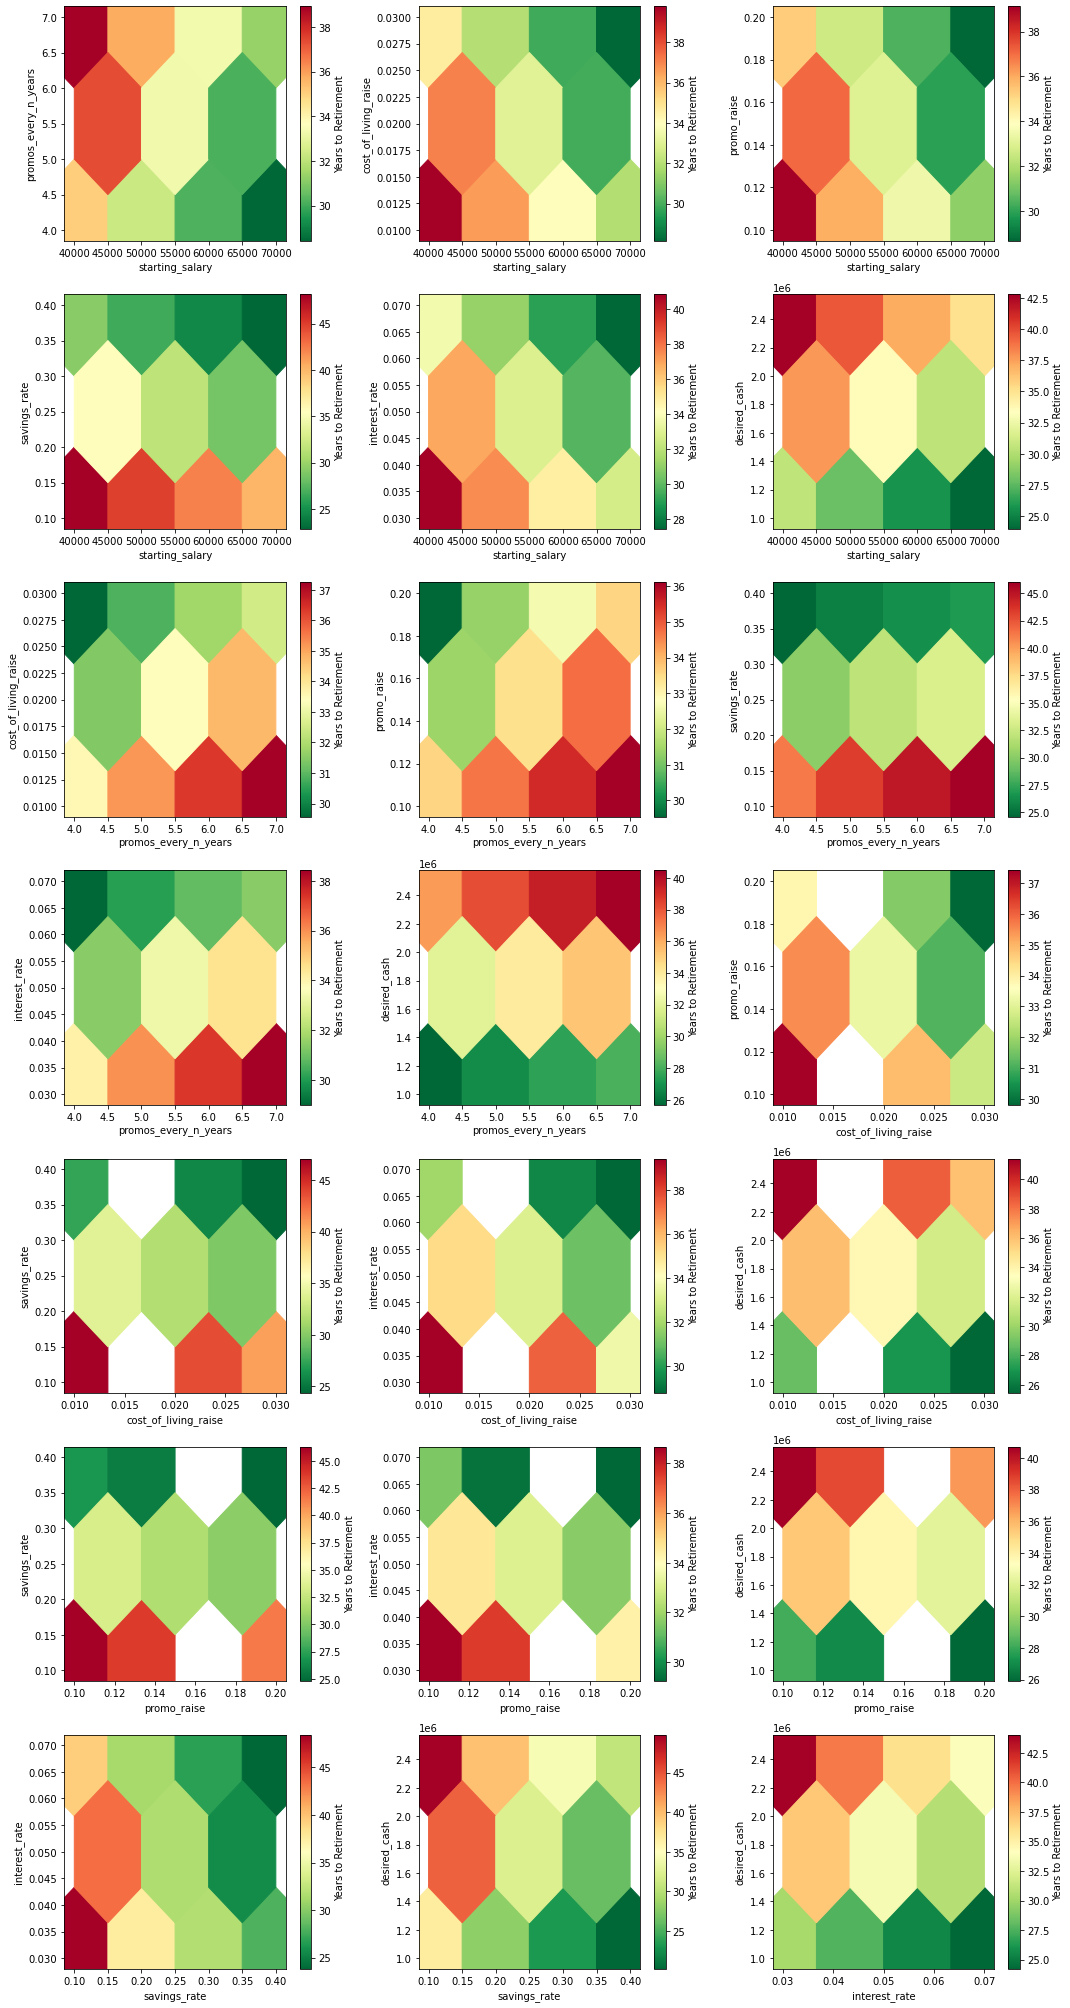

In [20]:
plot = sa.plot()

Display as styled DataFrames with conditional formatting. 

In [21]:
styled_dict = sa.styled_dfs(num_fmt='{:.1f}')

,4,5,6,7
starting_salary,,,,
40000,35.1,36.8,38.0,38.9
50000,32.4,33.9,35.0,35.8
60000,30.2,31.6,32.6,33.3
70000,28.4,29.7,30.6,31.3


,0.01,0.02,0.03
starting_salary,,,
40000,39.8,37.1,34.7
50000,36.6,34.2,32.0
60000,34.0,31.9,29.9
70000,32.0,29.9,28.2


,0.1,0.15,0.2
starting_salary,,,
40000,39.1,37.1,35.4
50000,36.0,34.2,32.6
60000,33.5,31.9,30.5
70000,31.4,30.0,28.7


,0.1,0.2,0.3,0.4
starting_salary,,,,
40000,48.1,38.3,33.0,29.3
50000,44.9,35.3,30.1,26.7
60000,42.3,33.0,27.9,24.6
70000,40.2,31.0,26.1,22.9


,0.03,0.04,0.05,0.06,0.07
starting_salary,,,,,
40000,42.3,39.4,36.9,34.7,32.7
50000,38.8,36.2,34.0,32.0,30.3
60000,36.0,33.7,31.7,29.9,28.3
70000,33.8,31.7,29.8,28.2,26.7


,1000000,1500000,2000000,2500000
starting_salary,,,,
40000,30.6,35.8,39.6,42.8
50000,27.9,32.9,36.6,39.6
60000,25.8,30.6,34.2,37.2
70000,24.0,28.7,32.3,35.1


,0.01,0.02,0.03
promos_every_n_years,,,
4,33.6,31.4,29.6
5,35.2,32.9,30.9
6,36.4,34.0,31.8
7,37.2,34.8,32.5


,0.1,0.15,0.2
promos_every_n_years,,,
4,33.6,31.4,29.5
5,34.7,32.9,31.4
6,35.5,34.0,32.6
7,36.1,34.8,33.6


,0.1,0.2,0.3,0.4
promos_every_n_years,,,,
4,41.2,32.5,27.8,24.6
5,43.4,34.0,29.0,25.6
6,44.9,35.1,29.9,26.3
7,46.0,36.0,30.5,26.9


,0.03,0.04,0.05,0.06,0.07
promos_every_n_years,,,,,
4,35.1,33.1,31.4,29.7,28.3
5,37.2,34.8,32.8,30.9,29.3
6,38.7,36.1,33.8,31.8,29.9
7,39.9,37.0,34.6,32.3,30.5


,1000000,1500000,2000000,2500000
promos_every_n_years,,,,
4,25.7,30.3,33.7,36.5
5,26.8,31.7,35.3,38.3
6,27.6,32.6,36.5,39.5
7,28.2,33.4,37.3,40.5


,0.1,0.15,0.2
cost_of_living_raise,,,
0.01,37.4,35.5,33.8
0.02,34.9,33.2,31.7
0.03,32.6,31.1,29.8


,0.1,0.2,0.3,0.4
cost_of_living_raise,,,,
0.01,47.1,36.7,31.1,27.4
0.02,43.8,34.3,29.2,25.8
0.03,40.8,32.2,27.5,24.4


,0.03,0.04,0.05,0.06,0.07
cost_of_living_raise,,,,,
0.01,41.0,37.9,35.3,32.9,30.9
0.02,37.5,35.2,33.1,31.2,29.5
0.03,34.6,32.7,31.1,29.5,28.1


,1000000,1500000,2000000,2500000
cost_of_living_raise,,,,
0.01,28.7,34.1,38.1,41.4
0.02,27.0,31.9,35.6,38.6
0.03,25.4,30.0,33.3,36.0


,0.1,0.2,0.3,0.4
promo_raise,,,,
0.1,46.3,36.1,30.6,27.0
0.15,43.8,34.3,29.2,25.8
0.2,41.5,32.8,28.0,24.8


,0.03,0.04,0.05,0.06,0.07
promo_raise,,,,,
0.1,40.1,37.2,34.7,32.4,30.5
0.15,37.6,35.1,33.1,31.2,29.5
0.2,35.4,33.4,31.7,30.0,28.5


,1000000,1500000,2000000,2500000
promo_raise,,,,
0.1,28.2,33.5,37.5,40.7
0.15,27.0,31.9,35.6,38.6
0.2,25.9,30.5,34.0,36.7


,0.03,0.04,0.05,0.06,0.07
savings_rate,,,,,
0.1,50.2,46.7,43.5,40.7,38.2
0.2,38.9,36.3,34.2,32.2,30.4
0.3,32.8,30.8,29.1,27.5,26.1
0.4,28.8,27.2,25.7,24.4,23.2


,1000000,1500000,2000000,2500000
savings_rate,,,,
0.1,36.8,42.4,46.5,49.8
0.2,28.0,33.0,36.8,39.8
0.3,23.3,28.0,31.5,34.4
0.4,20.2,24.6,28.0,30.7


,1000000,1500000,2000000,2500000
interest_rate,,,,
0.03,30.2,36.1,40.5,44.0
0.04,28.4,33.8,37.8,41.0
0.05,26.9,31.8,35.4,38.4
0.06,25.5,30.0,33.3,36.0
0.07,24.2,28.4,31.4,33.9


# Scenario Analysis

This section examines realistic cases of a bad and good economy and sees how it affects the years to retirement. The original result is the assumed case for a normal economy.

Note: This example shows external scenario analysis, which is easy to add to the model after you've built it. There is also internal scenario analysis which can be more appropriate if you're building scenarios into the model from the beginning. Since we already have an existing model, I will show external scenario analysis here.

## External

First I will set up the three cases of inputs for the bad economy, normal economy (baseline inputs), and good economy. All of the inputs are adjusted together.

In [22]:
bad_economy_data = ModelInputs(
    starting_salary=40000,
    promos_every_n_years=8,
    cost_of_living_raise=0.01,
    promo_raise=0.07,
    savings_rate=0.15,
    interest_rate=0.03,
)

good_economy_data = ModelInputs(
    starting_salary=70000,
    promos_every_n_years=4,
    cost_of_living_raise=0.03,
    promo_raise=0.20,
    savings_rate=0.35,
    interest_rate=0.06,
)

cases = {
    'Bad': bad_economy_data,
    'Normal': model_data, # Original inputs were set to assume a normal economy
    'Good': good_economy_data
}

Now run the model with each of the three cases, and display the results.

In [23]:
for case_type, case_inputs in cases.items():
    ytr = years_to_retirement(case_inputs, print_output=False)
    print(f'It would take {ytr} years to retire in a {case_type} economy.')

It would take 61 years to retire in a Bad economy.
It would take 28 years to retire in a Normal economy.
It would take 19 years to retire in a Good economy.


As we can see, if there were a sustained bad economy for the entire career, the individual would essentially never be able to retire, whereas if there was a sustained good economy for the entire career, the individual could retire almost 10 years earlier.

If we assign probabilities to these cases, we can also get a new expected years to retirement based on these probabilities.

In [24]:
case_probabilities = {
    'Bad': 0.2,
    'Normal': 0.5,
    'Good': 0.3
}

# Take expected value over the cases
expected_ytr = 0
for case_type, case_inputs in cases.items():
    ytr = years_to_retirement(case_inputs, print_output=False)
    weighted_ytr = ytr * case_probabilities[case_type]
    expected_ytr += weighted_ytr
print(f'It would take {expected_ytr:.0f} years to retire considering a {case_probabilities["Bad"]:.0%} chance of a bad economy and {case_probabilities["Good"]:.0%} chance of a good economy.')

It would take 32 years to retire considering a 20% chance of a bad economy and 30% chance of a good economy.


Considering the scenario analysis, we should expect that it takes a few years longer to retire than the baseline case, as the saving and investment potential is vastly lower in the bad economy. 

# Internal Randomness

It's not realistic for the economy to be bad or good for the entire career of the individual. Really, in a given year there should be some probability of whether it is a good/bad/neutral economy. So it really makes sense to build these scenarios inside the model rather than use them externally.

Note: Again, you would just pick one of internal or external but I show both for example. But, some planning is required, because if you already made the model and want to use internal scenario analysis, it requires rewriting parts of the model, whereas external can always be added on later. So here I will be rewriting portions of the model. But in a realistic problem I would have considered that by year probabilities of the cases are a lot more realistic, so I would have built out the model the first time with the scenarios already included. This will add substantially to the complexity of the model and so was not appropriate as the intro model.

In [25]:
@dataclass
class ModelInputs:
    starting_salary: tuple = (40000, 60000, 70000)
    promos_every_n_years: tuple = (8, 5, 4)
    cost_of_living_raise: tuple = (0.01, 0.02, 0.03)
    promo_raise: tuple = (0.07, 0.15, 0.2)
    savings_rate: tuple = (0.15, 0.25, 0.35)
    interest_rate: tuple = (0.03, 0.05, 0.06)
    desired_cash: int = 1500000
    recession_prob: float = 0.2
    expansion_prob: float = 0.3
    case_names: tuple = ('Recession', 'Normal', 'Expansion')
    n_iter: int = 1000
        
model_data = ModelInputs()
model_data

ModelInputs(starting_salary=(40000, 60000, 70000), promos_every_n_years=(8, 5, 4), cost_of_living_raise=(0.01, 0.02, 0.03), promo_raise=(0.07, 0.15, 0.2), savings_rate=(0.15, 0.25, 0.35), interest_rate=(0.03, 0.05, 0.06), desired_cash=1500000, recession_prob=0.2, expansion_prob=0.3, case_names=('Recession', 'Normal', 'Expansion'), n_iter=1000)

First create a function which determines which economy case we are in for a given year. Here I will number the cases as:

- 0: Bad economy
- 1: Normal economy
- 2: Good economy

As this lines up with how we've defined the inputs. The function will return the case number.

In [26]:
def get_economy_case_number(data):
    """
    Uses the probabilities of a bad and good economy to output the economy case number for a given year.
    
    0 corresponsds to a bad economy, 1 to a normal economy, and 2 to a good economy.
    """
    normal_probability = 1 - data.recession_prob - data.expansion_prob
    case_num = random.choices([0, 1, 2], weights=[data.recession_prob, normal_probability, data.expansion_prob])[0]
    return case_num


get_economy_case_number(model_data)

1

Now I will rewrite the main functions by replacing any access to the inputs as looking up the input for the case number, and making sure case is passed to each of the functions. Now the `years_to_retirement` function will also determine the economy case in each year.

In [27]:
def salary_at_year(data: ModelInputs, year, case):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years[case])
    
    # This is the formula above implemented in Python
    salary_t = data.starting_salary[case] * (1 + data.cost_of_living_raise[case]) ** year * (1 + data.promo_raise[case]) ** num_promos
    return salary_t


def cash_saved_during_year(data: ModelInputs, year, case):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year, case)
    cash_saved = salary * data.savings_rate[case]
    return cash_saved


def wealth_at_year(data: ModelInputs, year, prior_wealth, case):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year, case)
    wealth = prior_wealth * (1 + data.interest_rate[case]) + cash_saved
    return wealth


def years_to_retirement(data: ModelInputs, print_output=True):
    """
    The main model function which calculates the years to retirement based on the model inputs,
    calling the other functions to determine the salaries and wealths over time.
    """
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0

    year = 0  # will become 1 on first loop

    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        case = get_economy_case_number(data)  # 0 = recession, 1 = normal, 2 = expansion
        case_type = data.case_names[case]
        wealth = wealth_at_year(data, year, prior_wealth, case)
        if print_output:
            print(f'The wealth at year {year} ({case_type} economy) is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth

    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

We can see now that everything is working as expected. However now the model is internally random, so we must run it many times and take the expected value of the result.

In [28]:
years_to_retirement(model_data)

Wealths over time:
The wealth at year 1 (Normal economy) is $15,300.
The wealth at year 2 (Expansion economy) is $42,210.
The wealth at year 3 (Normal economy) is $60,239.
The wealth at year 4 (Normal economy) is $79,487.
The wealth at year 5 (Normal economy) is $102,507.
The wealth at year 6 (Recession economy) is $111,951.
The wealth at year 7 (Recession economy) is $121,743.
The wealth at year 8 (Normal economy) is $148,041.
The wealth at year 9 (Expansion economy) is $202,956.
The wealth at year 10 (Normal economy) is $237,285.
The wealth at year 11 (Expansion economy) is $300,358.
The wealth at year 12 (Expansion economy) is $378,741.
The wealth at year 13 (Recession economy) is $397,409.
The wealth at year 14 (Normal economy) is $443,455.
The wealth at year 15 (Expansion economy) is $536,020.
The wealth at year 16 (Normal economy) is $594,139.
The wealth at year 17 (Normal economy) is $655,790.
The wealth at year 18 (Normal economy) is $721,162.
The wealth at year 19 (Normal econ

24

Run the model for a number of iterations to see how long it would take to retire in each case, and print
some summary statistics.

In [29]:
def years_to_retirement_case_df(data):
    """
    Runs the model repeatedly based on the number of iterations and puts the resulting
    years to retirement in a DataFrame
    """
    all_ytrs = []
    for i in range(data.n_iter):
        ytr = years_to_retirement(data, print_output=False)
        all_ytrs.append(ytr)

    df = pd.DataFrame()
    df['Years to Retirement'] = all_ytrs
    return df

def summarize_ytr_df(df):
    """
    Summarizes the DataFrame which contains years to retirement from multiple runs
    of the model
    """
    avg_ytr = df['Years to Retirement'].mean()
    std_ytr = df['Years to Retirement'].std()
    max_ytr = df['Years to Retirement'].max()
    min_ytr = df['Years to Retirement'].min()

    print(
        f'It will take {avg_ytr:.0f} years to retire on average, with a standard deviation '
        f'of {std_ytr:.1f}, max of {max_ytr:.0f}, and min of {min_ytr:.0f}.'
    )
    

def years_to_retirment_cases_and_summarize(data):
    """
    Runs the model for the number of iterations in the inputs, extracts the years to 
    retirement, and summarizes the years to retirement across the iterations before 
    returning the DataFrame containing the years to retirement
    """
    df = years_to_retirement_case_df(data)
    summarize_ytr_df(df)
    return df

In [30]:
years_to_retirment_cases_and_summarize(model_data);

It will take 26 years to retire on average, with a standard deviation of 1.6, max of 31, and min of 21.
